# Mohammad ALI Mojtahed Soleimani

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, l1_lambda=0, l2_lambda=0, dropout_rate=0):
        super(SimpleCNN, self).__init__()
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Assuming input size of 224x224
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 102)  # Caltech-101 has 101 categories + background

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu3(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

    def l1_regularization_loss(self):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, 1)
        return self.l1_lambda * l1_loss

    def l2_regularization_loss(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)
        return self.l2_lambda * l2_loss

In [18]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
try:
    full_dataset = datasets.Caltech101(root='./data', download=True, transform=data_transform)
except RuntimeError as e:
    if "HTTP Error 503: Service Unavailable" in str(e):
        print("Error: Caltech-101 server might be unavailable. Try again later or use a different dataset.")
        exit()

Files already downloaded and verified


In [20]:
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Add L1 and/or L2 regularization loss if applicable
            if model.l1_lambda > 0:
                loss += model.l1_regularization_loss()
            if model.l2_lambda > 0:
                loss += model.l2_regularization_loss()

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Add L1 and/or L2 regularization loss if applicable
                if model.l1_lambda > 0:
                    loss += model.l1_regularization_loss()
                if model.l2_lambda > 0:
                    loss += model.l2_regularization_loss()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    # --- Testing ---
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy

In [23]:
num_epochs = 10  # You might need more epochs when using the full dataset
results = {}

In [24]:
# 1. No Regularization
print("Training without regularization:")
model_no_reg = SimpleCNN()
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy = train_and_evaluate(model_no_reg, train_loader, val_loader, test_loader, num_epochs)
results['No Regularization'] = (train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy)

Training without regularization:
Epoch [1/10], Train Loss: 3.7391, Train Acc: 27.73%, Val Loss: 3.0009, Val Acc: 38.41%
Epoch [2/10], Train Loss: 2.4678, Train Acc: 45.27%, Val Loss: 2.5698, Val Acc: 45.21%
Epoch [3/10], Train Loss: 1.4692, Train Acc: 63.87%, Val Loss: 2.7101, Val Acc: 45.10%
Epoch [4/10], Train Loss: 0.5760, Train Acc: 84.89%, Val Loss: 3.4883, Val Acc: 45.33%
Epoch [5/10], Train Loss: 0.1690, Train Acc: 95.76%, Val Loss: 4.8598, Val Acc: 43.94%
Epoch [6/10], Train Loss: 0.0735, Train Acc: 98.14%, Val Loss: 4.9386, Val Acc: 45.79%
Epoch [7/10], Train Loss: 0.0726, Train Acc: 98.21%, Val Loss: 5.5830, Val Acc: 43.83%
Epoch [8/10], Train Loss: 0.1079, Train Acc: 97.77%, Val Loss: 5.9090, Val Acc: 44.29%
Epoch [9/10], Train Loss: 0.0526, Train Acc: 98.80%, Val Loss: 6.0702, Val Acc: 44.98%
Epoch [10/10], Train Loss: 0.0182, Train Acc: 99.57%, Val Loss: 5.9613, Val Acc: 45.79%
Test Accuracy: 45.45%


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# 2. L1 Regularization
print("\nTraining with L1 Regularization:")
model_l1 = SimpleCNN(l1_lambda=0.001).to(device)
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy = train_and_evaluate(model_l1, train_loader, val_loader, test_loader, num_epochs)
results['L1 Regularization'] = (train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy)


Training with L1 Regularization:
Epoch [1/10], Train Loss: 7.2310, Train Acc: 18.71%, Val Loss: 6.1218, Val Acc: 24.80%
Epoch [2/10], Train Loss: 5.9719, Train Acc: 26.75%, Val Loss: 5.9867, Val Acc: 29.64%
Epoch [3/10], Train Loss: 5.9058, Train Acc: 32.70%, Val Loss: 5.9388, Val Acc: 35.64%
Epoch [4/10], Train Loss: 5.7651, Train Acc: 37.49%, Val Loss: 5.8469, Val Acc: 37.37%
Epoch [5/10], Train Loss: 5.6699, Train Acc: 41.06%, Val Loss: 5.7547, Val Acc: 40.25%
Epoch [6/10], Train Loss: 5.4151, Train Acc: 44.78%, Val Loss: 5.5863, Val Acc: 39.45%
Epoch [7/10], Train Loss: 5.3745, Train Acc: 46.69%, Val Loss: 5.6776, Val Acc: 41.29%
Epoch [8/10], Train Loss: 5.1749, Train Acc: 49.63%, Val Loss: 5.6088, Val Acc: 44.18%
Epoch [9/10], Train Loss: 5.0297, Train Acc: 51.52%, Val Loss: 5.5357, Val Acc: 43.60%
Epoch [10/10], Train Loss: 4.9769, Train Acc: 53.75%, Val Loss: 5.6582, Val Acc: 40.72%
Test Accuracy: 43.50%


In [ ]:
# 3. L2 Regularization
print("\nTraining with L2 Regularization:")
model_l2 = SimpleCNN(l2_lambda=0.001).to(device)
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy = train_and_evaluate(model_l2, train_loader, val_loader, test_loader, num_epochs)
results['L2 Regularization'] = (train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy)

In [ ]:
# 4. Dropout
print("\nTraining with Dropout:")
model_dropout = SimpleCNN(dropout_rate=0.5).to(device)
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy = train_and_evaluate(model_dropout, train_loader, val_loader, test_loader, num_epochs)
results['Dropout'] = (train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy)

NameError: name 'results' is not defined

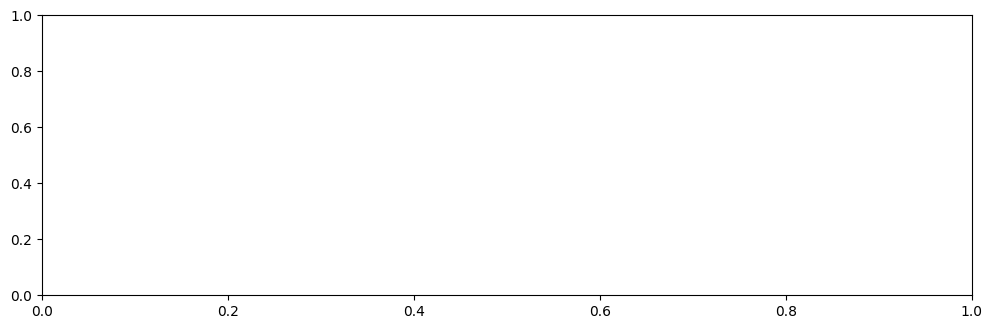

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for name, (train_losses, val_losses, _, _, _) in results.items():
    plt.plot(train_losses, label=f'{name} - Train Loss')
    plt.plot(val_losses, label=f'{name} - Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch for Different Regularization Methods')
plt.legend()


In [ ]:
plt.subplot(2, 1, 2)
for name, (_, _, train_accuracies, val_accuracies, _) in results.items():
    plt.plot(train_accuracies, label=f'{name} - Train Acc')
    plt.plot(val_accuracies, label=f'{name} - Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch for Different Regularization Methods')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("\nTest Accuracies:")
for name, (_, _, _, _, test_accuracy) in results.items():
    print(f"{name}: {test_accuracy:.2f}%")